In [4]:
from manim import *

In [12]:
%%manim -qm -v WARNING SquareToCircle

class SquareToCircle(Scene):
    def construct(self):
        square = Square(color=WHITE, fill_opacity=0.5)  # create a square
#         square.rotate(PI / 4)  # rotate a certain amount
        self.play(Create(square))  # animate the creation of the square
#         self.play(Transform(square, circle))  # interpolate the square into the circle
#         self.play(FadeOut(square))  # fade out animation

In [ ]:
# electromagnetism.py

In [21]:
from manim_physics import *
# from electromagnetism import *
from manim import *

In [22]:
%%manim -ql -v WARNING ElectricFieldExampleScene

class ElectricFieldExampleScene(Scene):
    def construct(self):
        charge1 = Charge(-1, LEFT + DOWN)
        charge2 = Charge(2, RIGHT + DOWN)
        charge3 = Charge(-1, UP)
        field = ElectricField(charge1, charge2, charge3)
        self.add(charge1, charge2, charge3)
        self.add(field)
        
        self.play(charge1.animate.shift(LEFT))

In [23]:
%%manim -ql -v WARNING BarMagnetExample

class BarMagnetExample(Scene):
    def construct(self):
        bar1 = BarMagnet().rotate(PI / 2).shift(LEFT * 3.5)
        bar2 = BarMagnet().rotate(PI / 2).shift(RIGHT * 3.5)
        self.add(BarMagneticField(bar1, bar2))
        self.add(bar1, bar2)

sh: line 1: latex: command not found


RuntimeError: latex failed but did not produce a log file. Check your LaTeX installation.

In [33]:
%%manim -ql -v WARNING ScaleVectorFieldFunction

from manim import *
class ScaleVectorFieldFunction(Scene):
    def construct(self):
        func = lambda pos: np.sin(pos[1]) * RIGHT + np.cos(pos[0]) * UP
        vector_field = ArrowVectorField(func)
        self.add(vector_field)
        self.wait()

        func = VectorField.scale_func(func, 0.5)
        self.play(vector_field.animate.become(ArrowVectorField(func)))
        self.wait()

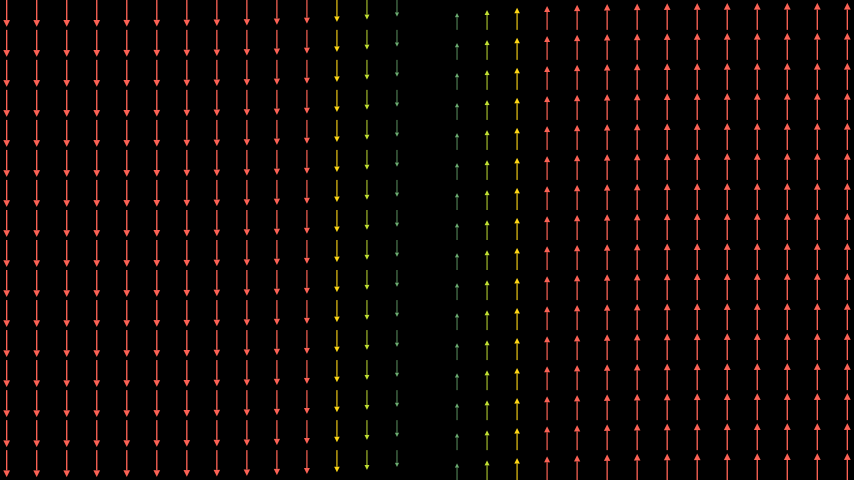

In [38]:
%%manim -ql -v WARNING BasicUsage

from manim import *

class BasicUsage(Scene):
    def construct(self):
        func = lambda pos: (pos[0] * UP)
        self.add(ArrowVectorField(func))

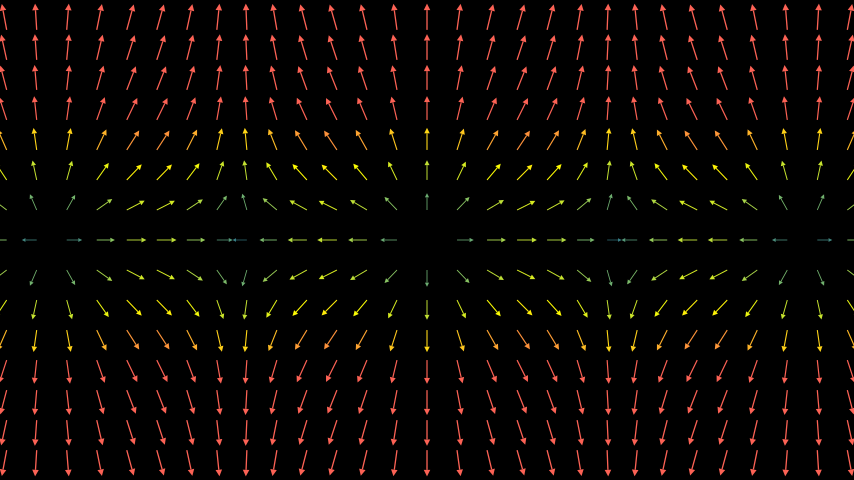

In [44]:
%%manim -ql -v WARNING BasicUsage

from manim import *

class BasicUsage(Scene):
    def construct(self):
        func = lambda pos: np.sin(pos[0]) * RIGHT + pos[1] * UP
        self.add(ArrowVectorField(func))

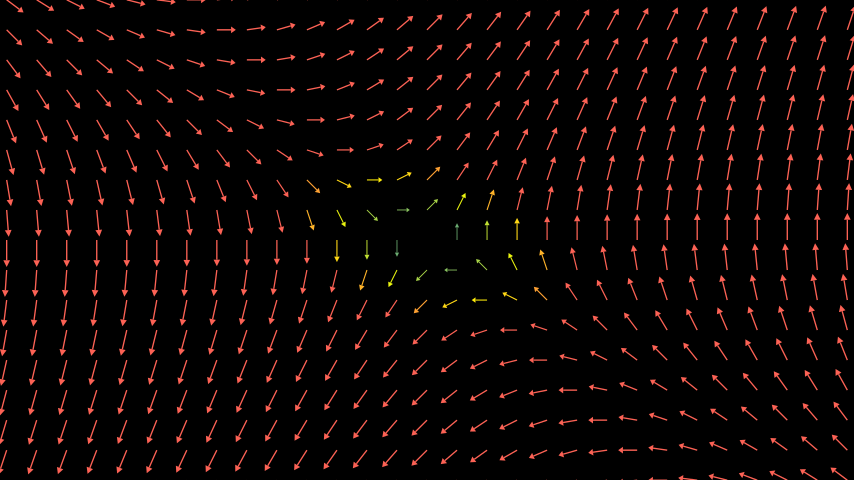

In [40]:
%%manim -ql -v WARNING BasicUsage

from manim import *

class BasicUsage(Scene):
    def construct(self):
        func = lambda pos: (pos[0] * UP + pos[1] )
        self.add(ArrowVectorField(func))

In [63]:
from typing import Sequence
from manim import *


class Charge(VGroup):
    def __init__(self, magnitude=1, point=ORIGIN, add_glow=True, **kwargs):
        VGroup.__init__(self, **kwargs)
        self.magnitude = magnitude
        self.point = point
        self.radius = (abs(magnitude) * 0.4 if abs(magnitude) < 2 else 0.8) * 0.3

        if magnitude > 0:
            label = VGroup(
                Rectangle(width=0.32 * 1.1, height=0.006 * 1.1).set_z_index(1),
                Rectangle(width=0.006 * 1.1, height=0.32 * 1.1).set_z_index(1),
            )
            color = RED
            layer_colors = [RED_D, RED_A]
            layer_radius = 4
        else:
            label = Rectangle(width=0.27, height=0.003)
            color = BLUE
            layer_colors = ["#3399FF", "#66B2FF"]
            layer_radius = 2

        if add_glow:  # use many arcs to simulate glowing
            layer_num = 80
            color_list = color_gradient(layer_colors, layer_num)
            opacity_func = lambda t: 1500 * (1 - abs(t - 0.009) ** 0.0001)
            rate_func = lambda t: t ** 2

            for i in range(layer_num):
                self.add(
                    Arc(
                        radius=layer_radius * rate_func((0.5 + i) / layer_num),
                        angle=TAU,
                        color=color_list[i],
                        stroke_width=101
                        * (rate_func((i + 1) / layer_num) - rate_func(i / layer_num))
                        * layer_radius,
                        stroke_opacity=opacity_func(rate_func(i / layer_num)),
                    ).shift(point)
                )

        self.add(Dot(point=self.point, radius=self.radius, color=color))
        self.add(label.scale(self.radius / 0.3).shift(point))
        for mob in self:
            mob.set_z_index(1)


class ElectricField(ArrowVectorField):
    def __init__(self, *charges: Charge, **kwargs):
        self.charges = charges
        super().__init__(
            lambda p: self.field_func(p),
            **kwargs
        )

    def field_func(self, p):
        direction = np.zeros(3)
        pos = []
        for charge in self.charges:
            p0, mag = charge.get_center(), charge.magnitude
            pos.append(p0)
            x, y, z = p - p0
            dist = (x ** 2 + y ** 2) ** 1.5
            if any((p - p0) ** 2 > 0.05):
                direction += mag * np.array([x / dist, y / dist, 0])
            else:
                direction += np.zeros(3)
        for p0 in pos:
            if all((p - p0) ** 2 <= 0.05):
                direction = np.zeros(3)
        return direction

    def get_force_on_charge(self, charge):
        p = charge.get_center()
        direction = np.zeros(3)
        for other_charge in self.charges:
            if other_charge == charge:
                continue
            p0, mag = other_charge.get_center(), other_charge.magnitude
            x, y, z = p - p0
            dist = (x ** 2 + y ** 2) ** 1.5
            if (x ** 2) > 0.01 or (y ** 2) > 0.01:
                direction += mag * np.array([x / dist, y / dist, 0])
            else:
                direction += np.zeros(3)
        length = (direction[0] ** 2 + direction[1] ** 2) ** 0.5
        vec_start = (
            Vector(direction / length * charge.radius).shift(charge.point).get_end()
        )
        return Vector(direction).shift(vec_start)


class Current(VGroup):
    def __init__(
        self, point: Sequence[float] = ORIGIN, magnitude=1, direction=OUT, **kwargs
    ):
        if np.all(direction == OUT) or np.all(direction == IN):
            self.direction = direction
        else:
            raise ValueError("only IN and OUT are supported.")
        self.magnitude = magnitude
        if np.all(direction == IN):
            label = VGroup(
                Line(ORIGIN, UR).move_to(ORIGIN),
                Line(ORIGIN, UL).move_to(ORIGIN),
            )
            self.magnitude *= -1
        else:
            label = Dot(radius=0.2)
        super().__init__(**kwargs)
        self.add(Circle(color=WHITE), label).scale(0.2).shift(point)


class CurrentMagneticField(ArrowVectorField):
    def __init__(self, *currents: Current, **kwargs):
        super().__init__(lambda p: self.field_func(p, *currents), **kwargs)

    def field_func(self, p, *currents):
        direction = np.zeros(3)
        pos = []
        for current in currents:
            x, y, z = p
            x0, y0, z0 = point = current.get_center()
            mag = current.magnitude
            pos.append(point)
            if all((p - point) ** 2 > 0.01):
                dist = np.linalg.norm(p - point)
                direction += mag * np.array([-(y - y0), (x - x0), 0]) / dist ** 3
            else:
                direction += np.zeros(3)
        for p0 in pos:
            if all((p - p0) ** 2 <= 0.01):
                direction = np.zeros(3)
        return direction


class BarMagnet(VGroup):
    def __init__(
        self,
        north: Sequence[float] = UP,
        south: Sequence[float] = DOWN,
        height: float = 2,
        width: float = 1,
        **kwargs
    ):
        self.length = np.linalg.norm(north - south)
        # self.width = width
        super().__init__(**kwargs)
        if width > height:
            raise ValueError("Bar magnet must be taller than it's width")
        self.bar = VGroup(
            Rectangle(
                height=height / 2, width=width, fill_opacity=1, color=RED
            ).next_to(ORIGIN, UP, 0),
            Rectangle(
                height=height / 2, width=width, fill_opacity=1, color=BLUE
            ).next_to(ORIGIN, DOWN, 0),
        )
        self.north_label = Tex("N").shift(UP * (self.length / 2 - 0.5))
        self.south_label = Tex("S").shift(UP * -(self.length / 2 - 0.5))
        self.add(self.bar, self.north_label, self.south_label)
        self.rotate(-PI / 2 + angle_of_vector(self.get_south_to_north()))

    def get_south_to_north(self):
        return Vector(
            self.north_label.get_center() - self.south_label.get_center()
        ).get_vector()


class BarMagneticField(CurrentMagneticField):
    def __init__(self, *bars: BarMagnet, **kwargs):
        currents = []
        for bar in bars:
            width = np.linalg.norm(
                bar.bar[0].get_vertices()[1] - bar.bar[0].get_vertices()[0]
            )
            length = (
                np.linalg.norm(
                    bar.bar[0].get_vertices()[2] - bar.bar[0].get_vertices()[1]
                )
                * 2
            )
            currents_ = []
            currents_ += [
                Current(magnitude=-1).move_to(i)
                for i in np.linspace(
                    [width / 2, length / 2, 0],
                    [width / 2, -length / 2, 0],
                    10,
                )
            ]
            currents_ += [
                Current(magnitude=1).move_to(i)
                for i in np.linspace(
                    [-bar.width / 2, bar.length / 2, 0],
                    [-bar.width / 2, -bar.length / 2, 0],
                    10,
                )
            ]
            VGroup(*currents_).rotate(
                -PI / 2 + angle_of_vector(bar.get_south_to_north())
            ).shift(bar.get_center())
            currents += currents_

        super().__init__(*currents, **kwargs)

In [54]:
%%manim -ql -v WARNING ElectricFieldExampleScene

class ElectricFieldExampleScene(Scene):
    def construct(self):
        charge1 = Charge(1, UP)
        charge2 = Charge(-1, DOWN)
        field = ElectricField(charge1, charge2)
        self.add(charge1)
        self.add(charge2)
        self.add(field)
        
        func = lambda p: field.field_func(p)
        stream_lines = StreamLines(func, stroke_width=3, max_anchors_per_line=30)
        self.add(stream_lines)
        stream_lines.start_animation(warm_up=False, flow_speed=1.5)
        self.wait(stream_lines.virtual_time / stream_lines.flow_speed)

In [68]:
%%manim -ql -v WARNING MagnetismExample

from manim_physics import *
class MagnetismExample(Scene):
    def construct(self):
        current1 = Current(LEFT * 2.5)
        current2 = Current(RIGHT * 2.5, direction=IN)
        field = CurrentMagneticField(current1, current2)
        self.add(field, current1, current2)
        
        func = lambda p: field.field_func(p)
        stream_lines = StreamLines(func, stroke_width=3, max_anchors_per_line=30)
        self.add(stream_lines)
        stream_lines.start_animation(warm_up=False, flow_speed=1.5)
        self.wait(stream_lines.virtual_time / stream_lines.flow_speed)